# Unique Insertion Analysis

## Overview:
- Intended to use for counting number of unique UMIs given putative insertion reads (single-end only). 
- Reads are filtered to contain both the donor sequence and the target sequence with fuzzy string matching
- Global parameters are at the top, files are read in as .fastq files, sample sheet gives donor/target sequence, RC, and file/sample names
- Can also plot the distribution of UMI read counts, plot insertion site positions, and return .fastq files containing insertion reads
- Optional parallelization across samples for faster run time

## To Do:
- Fix false UMI reads that are shifts of existing UMIs due to indels between LE and UMI in reads
- Possibly use Gini coefficient or UMI entropy to provide a measure on the read distribution of UMIs?
- Add paired end functionality
- Currently does naive deduplication by UMI for insertion position, could modify to check for UMI collisions
- Figure out why it takes a while for pool to close in parallelized counter
- Automate .fastq generation if it would be helpful...

### Modified from Alim/Makoto's original script

In [2]:
# Parameters to modify

#General Params
UMI_start = 97 # Distance from start of donor sequence to start of UMI
UMI_length = 6 # Length of UMI to count
experiment_marker = ".fastq" #File format to read in (Doesn't actually work for anything but .fastq :P )
paired_end = False #Paired-end or single-end, still under development

#Fuzzy string matching matches more reads, but also takes longer to run
allow_errors = True # Setting for whether to allow errors in target/donor sequence match, T/F
donor_errors = 2 # Number of errors (indels, substitions) to allow between reads and donor sequence to match
target_errors = 3 # Number of errors (indels, substitions) to allow between reads and target sequence to match

#Optional filtering for insertion position
filter_insert_position = False # Setting for whether to threshold allowed insertion positions, T/F
insert_pos_min = 80 # Minimum insertion position, inclusive, relative to start of donor if filtering on
insert_pos_max = 100  # Maximum insertion position, inclusive, relative to start of donor if filtering on

In [3]:
#Import helpful packages
import csv
import itertools
import sys
import os
import math
import numpy as np
from tqdm.notebook import tnrange, tqdm_notebook, tqdm

#Packages for data analysis and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Packages for sequence parsing
import regex as re #Different from re from Alim's script, allows fuzzy matching
from Bio import SeqIO

#Packages for parallelization
from multiprocess import Pool
import psutil
from functools import partial

## Helper Functions

In [4]:
def sort_R_file(file_list):
    '''
    Sorts read files by name to determine forward/reverse read (relevant for paired end)
    '''
    sorted_list = ['','']
    for file in file_list:
        if 'R1_' in file:
            sorted_list[0] = file
        else:
            sorted_list[1] = file
    return sorted_list

In [5]:
def insertion_counter(fastq_f_r1, target, donor, rev_com):
    '''
    Processes .fastq files to count insertion reads and output statistics as well as dictionary of UMIs and counts,
        insertion positions, insertion positions for each UMI, and reads to generate a .fastq
    Inputs:
        fastq_f_r1: file name of relevant fastq file, as a string
        target: target sequence to match, as a string
        donor: donor sequence to match, as a string
        rev_com: reverse complement param, as a boolean (int of 0 or 1)
        Implicitly takes in many params related to UMI position, length, fuzzy string matching, and filtering
    Outputs:
        Prints # of reads, # of insertion reads, # of unique UMIs
        insertion_dict: stores UMIs as keys with counts per UMI as values
        insert_pos_list: list of insertion positions
        UMI_insert_pos_list: list of insertion positions deduplicated by UMI
        insertion_read_list: list of reads that are insertions, for later output as a .fastq for examination
    '''
    # Initialize variables
    num_reads = 0
    insertion_reads = 0
    unique_insertion_reads = 0
    insertion_dict = {} 
    insert_pos_list = [] 
    UMI_insert_pos_list = []
    insertion_read_list = []
    
    # Process input strings and define regexes
    target = target.upper()
    donor = donor.upper()   
    if allow_errors:
        target_error_string = "{"+f"e<={target_errors}"+"}"
        donor_error_string = "{"+f"e<={donor_errors}"+"}"     
        target_pattern = f"(?e)({target}){target_error_string}"
        donor_pattern = f"(?e)({donor}){donor_error_string}"
    else:
        target_pattern = target
        donor_pattern = donor


    # Extract and iterate through reads from .fastq file
    readiter_f = SeqIO.parse(fastq_f_r1, "fastq")
    pbar2 = tqdm(readiter_f)
    for record_f in pbar2:
        num_reads += 1
        read_sequence_f = str.upper(str(record_f.seq))
        if rev_com:
            read_sequence_f = str.upper(str(record_f.seq.reverse_complement()))
            
        # Search for target and donor match, store and record relevant information
        target_match = re.search(target_pattern, read_sequence_f)
        if target_match:
            donor_site = re.search(donor_pattern, read_sequence_f)
            if donor_site:
                    target_insertion = donor_site.start()-target_match.start()
                    UMI_seq = read_sequence_f[donor_site.start()+UMI_start:donor_site.start()+UMI_start+UMI_length]
                    if (insert_pos_min <= target_insertion <= insert_pos_max) or (not filter_insert_position):
                        insertion_reads +=1
                        insert_pos_list.append(target_insertion)
                        insertion_read_list.append(record_f)
                        if UMI_seq not in insertion_dict:
                            unique_insertion_reads += 1
                            UMI_insert_pos_list.append(target_insertion)                        
                        insertion_dict[UMI_seq] = insertion_dict.get(UMI_seq, 0) + 1
    pbar2.close()
                
    # Print Stats
    print(num_reads,"total reads, ",insertion_reads," insertion reads ", unique_insertion_reads, "unique insertion_reads" )
    
    return [insertion_dict, insert_pos_list, UMI_insert_pos_list, insertion_read_list]

In [6]:
def insertion_counter_parallel(sample_index):
    '''
    Helper function to parallelize insertion counter
    Processes .fastq files to count insertion reads and output statistics as well as dictionary of UMIs and counts,
        insertion positions, insertion positions for each UMI, and reads to generate a .fastq
    Inputs:
        sample_index: index of sample as string (e.g. "A12")
        Implicitly takes in many params related to UMI position, length, fuzzy string matching, and filtering
        Also takes in params that are in df containing sample information
    Outputs:
        Prints # of reads, # of insertion reads, # of unique UMIs
        insertion_dict: stores UMIs as keys with counts per UMI as values
        insert_pos_list: list of insertion positions
        UMI_insert_pos_list: list of insertion positions deduplicated by UMI
        insertion_read_list: list of reads that are insertions, for later output as a .fastq for examination
    '''
    #Get sample data and input into insertion_counter
    sample = samples.loc[sample_index,:]

    fastq_f_r1 = sample['Forward']
    target = sample['Target']
    donor = sample['Donor']
    rev_com = sample['Reverse Complement']
    intermediate_data = insertion_counter(fastq_f_r1, target, donor, rev_com)
    print(sample['Name'])
    return [sample['Name'], intermediate_data]

In [7]:
def insertion_pos_plot(sample_name, deduplicated_by_UMI, print_out):
    '''
    Takes in sample names and a few params and plots plot of insertion positions
    Inputs:
        sample_name = sample name as string
        deduplicated_by_UMI = Boolean for whether to look at insertion pos with or without deduplication
        print_out = Boolean for whether to print out list of insertion positions or not
    Outputs:
        Graph of insertion positions
        Prints out relevant insertion pos list dependent on print_out parameter
    '''
    #Acquire data
    if sample_name not in data:
        raise ValueError("Sample not found")
    if deduplicated_by_UMI:
        insertion_positions = np.array(data[sample_name][2])
    else:
        insertion_positions = np.array(data[sample_name][1])

    #Set up plot
    left_of_first_bin = insertion_positions.min() - 0.5
    right_of_last_bin = insertion_positions.max() + 0.5
    plt.figure(figsize=(9, 6)) 
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  
    plt.xlabel("Insertion Position", fontsize=16)  
    plt.ylabel("Count", fontsize=16)
    plt.hist(insertion_positions, np.arange(left_of_first_bin, right_of_last_bin + 1, 1), color="#3F5D7D")
    plt.show()
    
    #Print data if desired
    if print_out:
        print(*insertion_positions)

In [8]:
def UMI_dist_plot(sample_name, scale, print_out, print_counts):
    '''
    Takes in sample name and plots plot of read counts per UMI
    Inputs:
        sample_name = sample name as string
        scale = "Log" or "Linear"
        print_out = Boolean for whether to print out UMIs or not
        print_counts = Boolean for whether to print out UMI counts or not
    Outputs:
        Graph of insertion positions
        Prints out relevant data dependent on print parameters
    '''
    #Acquire data
    if sample_name not in data:
        raise ValueError("Sample not found")
    else:
        sample_UMI_dict = data[sample_name][0]

    
    #Set up data for plot
    counts = []
    UMIlabels = []
    for UMI, count in sample_UMI_dict.items():
        UMIlabels.append(UMI)
        counts.append(count)
    sorted_inds = np.array(counts).argsort()
    sorted_counts = np.array(counts)[sorted_inds[::-1]]
    sorted_UMIlabels = np.array(UMIlabels)[sorted_inds[::-1]]
    
    #Set up plot
    plt.figure(figsize=(20, 8)) 
    plt.bar(np.arange(len(sorted_counts)),sorted_counts)
    plt.xticks(fontsize=2)  
    plt.yticks(fontsize=14)
    if scale == "Log":
        plt.yscale('log')
    elif scale != "Linear":
        raise ValueError("Scale parameter is not defined correctly")
    plt.xlabel("UMI # sorted by count", fontsize=16)  
    plt.ylabel("Read Count", fontsize=16)
    plt.show()

    #Print data if desired
    if print_out:
        if print_counts:
            print(*zip(sorted_UMIlabels, sorted_counts))   
        else:
            print(*sorted_UMIlabels)
    elif print_counts:
        print(*sorted_counts)

In [9]:
def write_fastq(sample_name, file_name):
    '''
    Takes in sample name and writes reads to fastq file
    Inputs:
        sample_name = sample name as string
        file_name = output file name as string
    Outputs:
        .fastq file in same working directory containing filtered reads
    '''
    #Acquire data
    if sample_name not in data:
        raise ValueError("Sample not found")
    else:
        sample_reads = data[sample_name][3]

    #Write reads to file
    if ".fastq" not in file_name:
        raise ValueError("File name not valid")
    with open(file_name, "w") as output_handle:
        SeqIO.write(sample_reads, output_handle, "fastq")
    print(f"Reads written to: {file_name}")

## Main Script

In [10]:
#Lists and stores names of all unzipped .fastq files from current folder
#Note: identifies samples by second term in .fastq name (applies to standard lab BCs, but not everyone's)
cwd = os.getcwd()
files = os.listdir(cwd)
file_dict = {}
for file in files:
    if experiment_marker in file and '.gz' not in file:
        sample = file.split('_')
        try: 
            if sample[1] in file_dict:
                file_dict[sample[1]].append(file)
            else:
                file_dict[sample[1]] = [file]
        except:
            raise ValueError("Folder contains .fastq file not fitting correct format")
print(file_dict)

{'A9': ['P8_A9_S681_R1_001.fastq'], 'A11': ['P8_A11_S684_R1_001.fastq'], 'B5': ['P8_B5_S689_R1_001.fastq'], 'A12': ['P8_A12_S684_R1_001.fastq'], 'A4': ['P8_A4_S676_R1_001.fastq'], 'B7': ['P8_B7_S691_R1_001.fastq']}


In [11]:
#Import Sample Sheet
samples = pd.read_csv('Analysis_Sample_Sheet.csv', index_col = 0)
for sample in samples.index.tolist():
    fwd_file, rev_file = sort_R_file(file_dict[sample])
    samples.loc[sample,'Forward'] = fwd_file
    if paired_end:
        samples.loc[sample, 'Reverse'] = rev_file #Empty string if no reverse read
display(samples)

,Name,Target,Donor,Reverse Complement,Forward
Sample,,,,,
A12,Sample,TTAGACCCATGGGAGCAGCTGGTCAGAGGGGACCCCGGCCTGGGGC...,TGTGACTTTACCCATA,0,P8_A12_S684_R1_001.fastq
A4,IB43-ID4_uL,TGATGGGAGCCCTTCTTCTTCTGCTCGGACTCAGGCCCTTCCTCCT...,TGTGACTTTACCCATA,0,P8_A4_S676_R1_001.fastq
A9,IB43-ID9_uL,GGAAGACTGAGGCTACATAGGGTTAGGGGCCCCAGGCCGGGGTCCC...,TGTGACTTTACCCATA,0,P8_A9_S681_R1_001.fastq
B5,IB43-ID17_uL,TCTGTTACTCGCCTGTCAAGTGGCGTGACACCGGGCGTGTTCCCCA...,TGTGACTTTACCCATA,0,P8_B5_S689_R1_001.fastq
B7,IB43-ID19_uL,CACTGATGTTGTGTTTTTAACATGTCAATCTGTCCGTTCACATGTG...,TGTGACTTTACCCATA,0,P8_B7_S691_R1_001.fastq


In [11]:
#Count insertion reads and process data for further analysis
pbar = tqdm(samples.index.tolist()[:])
data = {}
for index in pbar:
    sample = samples.loc[index,:]
    sample_data = insertion_counter(sample['Forward'], sample['Target'], sample['Donor'], sample['Reverse Complement'])
    print(sample['Name'])
    if sample['Name'] not in data:
        data[sample['Name']] = sample_data
    else:
        raise ValueError("Multiple samples with same name")
pbar.close()


192575 total reads,  1829  insertion reads  277 unique insertion_reads
Sample



232934 total reads,  19  insertion reads  3 unique insertion_reads
IB43-ID4_uL



233191 total reads,  2053  insertion reads  322 unique insertion_reads
IB43-ID9_uL



116290 total reads,  643  insertion reads  69 unique insertion_reads
IB43-ID17_uL



61285 total reads,  58104  insertion reads  150 unique insertion_reads
IB43-ID19_uL



In [12]:
#Optional parallelized version (should be faster than the above given enough samples, is parallelized across samples)
#Takes a bit to close the pool, but results generated quickly
data = {}
pool = Pool(psutil.cpu_count(logical=False))
for [sample_name, processed_sample_data] in pool.imap(insertion_counter_parallel, samples.index.tolist()):
    if sample_name not in data:
        data[sample_name] = processed_sample_data
    else:
        raise ValueError("Multiple samples with same name")
pool.close()


116290 total reads,  643  insertion reads  69 unique insertion_reads
IB43-ID17_uL



61285 total reads,  58104  insertion reads  150 unique insertion_reads
IB43-ID19_uL

192575 total reads,  1829  insertion reads  277 unique insertion_reads
Sample

233191 total reads,  2053  insertion reads  322 unique insertion_reads
IB43-ID9_uL

232934 total reads,  19  insertion reads  3 unique insertion_reads
IB43-ID4_uL


## Insertion Position Analysis

In [13]:
help(insertion_pos_plot)

Help on function insertion_pos_plot in module __main__:

insertion_pos_plot(sample_name, deduplicated_by_UMI, print_out)
    Takes in sample names and a few params and plots plot of insertion positions
    Inputs:
        sample_name = sample name as string
        deduplicated_by_UMI = Boolean for whether to look at insertion pos with or without deduplication
        print_out = Boolean for whether to print out list of insertion positions or not
    Outputs:
        Graph of insertion positions
        Prints out relevant insertion pos list dependent on print_out parameter



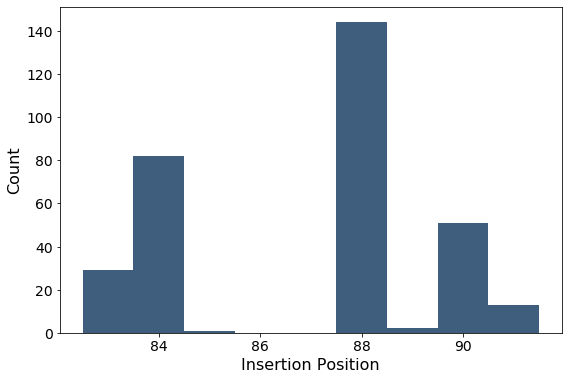

88 88 90 88 88 83 88 88 90 88 91 84 88 83 88 88 88 88 88 90 84 88 90 90 88 83 90 84 84 91 84 88 84 90 88 88 90 84 90 84 84 88 88 90 88 83 90 90 83 88 84 83 88 84 88 91 88 84 88 88 88 84 88 84 88 84 91 88 88 88 90 83 88 88 88 84 84 88 88 84 84 88 83 88 90 88 84 88 88 84 88 84 84 83 88 88 84 90 90 88 90 83 84 88 84 90 84 88 88 90 91 84 88 90 88 88 84 88 88 83 88 88 88 83 89 84 90 88 88 88 84 88 88 84 84 90 90 90 88 90 83 88 83 84 88 91 88 88 88 84 90 88 84 88 84 84 84 88 88 84 83 88 84 84 83 91 90 90 88 90 84 88 88 90 84 88 88 83 90 88 84 84 84 90 88 88 84 88 90 88 90 88 84 88 88 90 84 84 88 84 91 88 88 88 88 84 88 88 88 88 88 84 83 84 88 88 90 83 88 84 88 90 84 88 83 83 88 83 84 88 88 85 88 84 84 88 90 90 91 88 88 84 90 88 88 91 84 83 90 84 88 88 90 90 84 88 84 84 84 89 83 83 88 88 88 88 88 84 84 84 90 88 84 88 88 88 88 90 84 88 88 84 88 88 88 88 84 90 88 83 88 90 84 88 90 88 90 88 84 88 84 88 83 84 88 90 83 88 84 88 90 84 88 91 88 83 88 88 84 91 91 84


In [14]:
# Plot of insertion positions not deduplicated by UMI
insertion_pos_plot("IB43-ID9_uL", True, True)

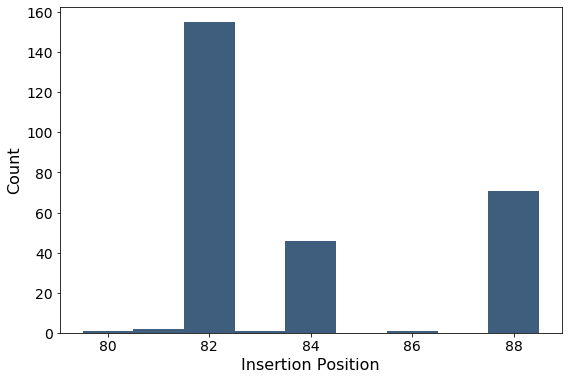

In [15]:
# Plot of insertion positions deduplicated by UMI
insertion_pos_plot("Sample", True, False)

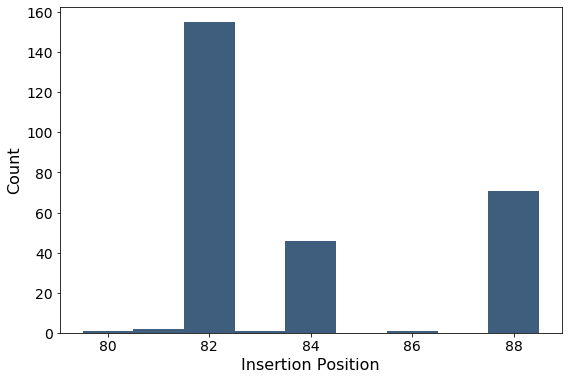

84 82 82 82 84 88 84 82 82 88 82 82 82 82 82 88 88 84 82 82 82 88 82 84 88 82 82 82 82 82 82 82 84 82 82 88 84 88 88 88 82 82 82 84 84 82 88 82 82 82 82 82 88 88 82 82 82 84 82 82 82 88 82 88 82 80 82 88 82 82 84 88 82 88 82 88 84 82 82 88 82 82 88 82 82 88 82 82 82 88 82 82 82 82 82 88 88 82 88 84 84 82 88 88 86 84 88 82 82 84 82 82 81 84 82 82 82 82 88 82 88 84 88 82 88 82 82 88 88 88 84 88 82 84 82 82 84 88 88 88 82 84 82 82 84 84 82 82 84 84 84 82 88 82 82 84 84 82 88 82 82 82 88 82 82 84 82 82 88 84 82 82 88 88 88 82 88 82 82 88 82 82 82 82 82 88 82 88 82 84 82 84 88 82 88 88 82 88 82 88 82 82 82 82 82 82 88 82 84 82 82 88 82 81 82 82 82 82 82 84 82 84 82 88 82 84 82 84 82 82 88 82 83 88 82 82 88 82 82 84 84 82 82 82 88 82 88 88 82 82 82 84 88 82 82 84 84 88 82 82 82 82 82 88 82 84 88 82 88 82 82 82 84 88 84 82 82


In [16]:
# Print-out of insertion positions deduplicated by UMI
insertion_pos_plot("Sample", True, True)

## UMI Read Distribution Analysis

In [17]:
help(UMI_dist_plot)

Help on function UMI_dist_plot in module __main__:

UMI_dist_plot(sample_name, scale, print_out, print_counts)
    Takes in sample name and plots plot of read counts per UMI
    Inputs:
        sample_name = sample name as string
        scale = "Log" or "Linear"
        print_out = Boolean for whether to print out UMIs or not
        print_counts = Boolean for whether to print out UMI counts or not
    Outputs:
        Graph of insertion positions
        Prints out relevant data dependent on print parameters



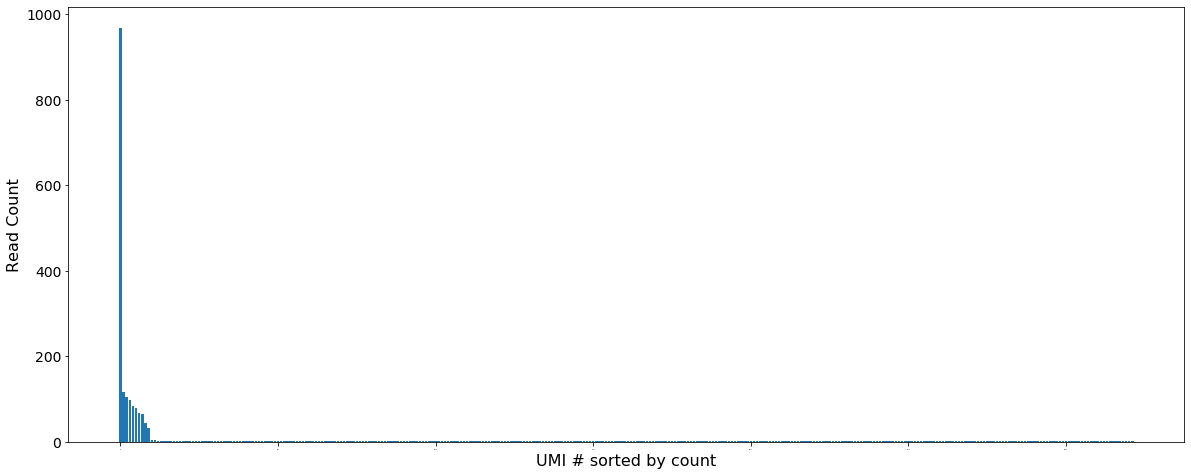

In [18]:
# UMI read plot with linear scale
UMI_dist_plot("IB43-ID9_uL", "Linear", False, False)

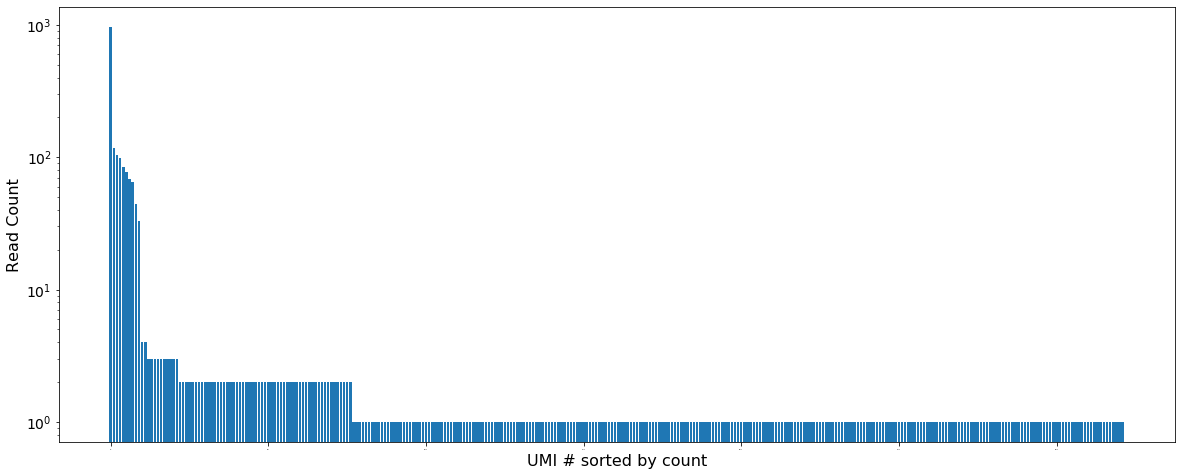

969 117 104 98 84 78 68 65 44 33 4 4 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


In [19]:
# UMI read plot with linear scale
UMI_dist_plot("IB43-ID9_uL", "Log", False, True)

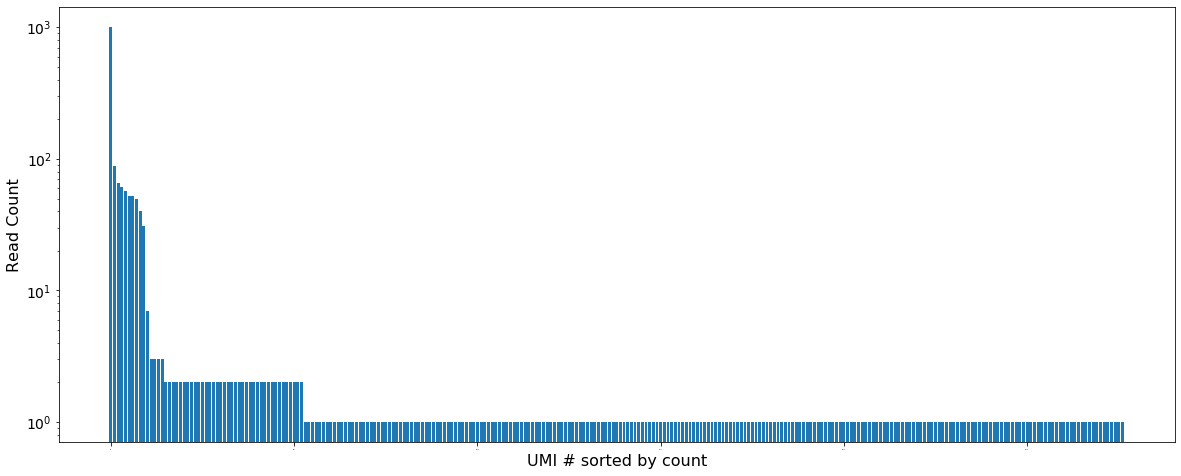

In [20]:
# UMI read plot with log scale
UMI_dist_plot("Sample", "Log", False, False)

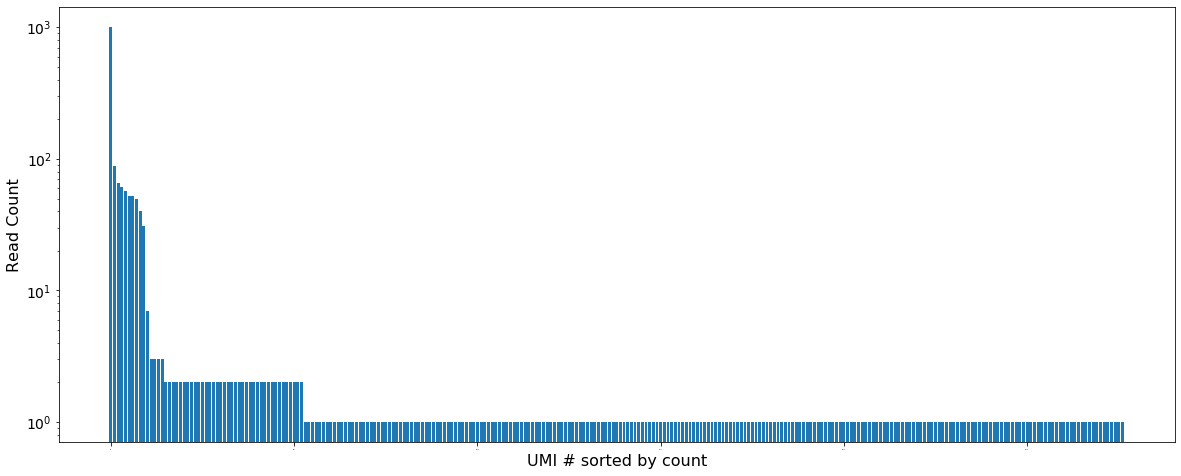

GCTAAC GGTCTA CATCAT GCTTCC CTAAAT CATAGA TAATTG TGCTAA AAGTTT TCCTCA TCTAAC AAGGTC GATAAC AGTTTG GACGAA GCGTAG AAGCAA CTAACT TGAGAA TGTCGT CGAAAC CACCTA GAAGCA AACCAT GACAAC ACTCTG ACAAAT TCATTC GCGGGG GGATGG GGAATA CTACTA AAACTC TTGTAT TCCCGA ATCACC AGATTC CTTGGG AGAGGC AAGCCC GTACTC TTGCCA AAGGAG TTTGGG AATGTG GCTACA CACAAA TATAGC TGATGA GACGCC TAAAAG GCGAAC AGCCGG GTAGAT GTCTAC GGACGA TAGTGT CTAAGA CTTACC TTATTG GTCACC GAAGTA GTCAAA GATCGA TTAGAC AACCGC CAGTGA AATATT AACACG AACTAG AGTAAG CTTGTG GAACAC GGCCGA TCATAA ATTAAT CCGCCA AGGCTG TGTCTT GCTAAA AAACGC AGCCTT TTCCTA CGGTAG GAGAAT AGAATT AATGCC AAGTAC ACGATT GTCCAT TAGGTG ACTTTA TTTCAT CCGCGG TATCGG TACGTC ATGTGA TTGCGA AAGAAT CGGAGG ACCGTT CCAGCC ATGGCG GACTGA GCTTTC GTTTGC TAAGTT CTATCC GCGCCT TGGATC GTCAAT GGACTA CAATCG AGGTCC GTGCCT AGTTTT TGGTAG TGACCC AGCTAT ATTACC CATCTG ACTTAT GCTCGC GTATTG AATAGA CTCTGG TACGTG GTTTAA TTATTT ATGATG CAGGCT CGAGAT AAAACG TGTATG TTGTCT TAGTTG CTCATC TACTCA CACGTC ACACCT CAATTT AGTTGG AGCAAA

In [21]:
# Print-out of UMIs
UMI_dist_plot("Sample", "Log", True, False)

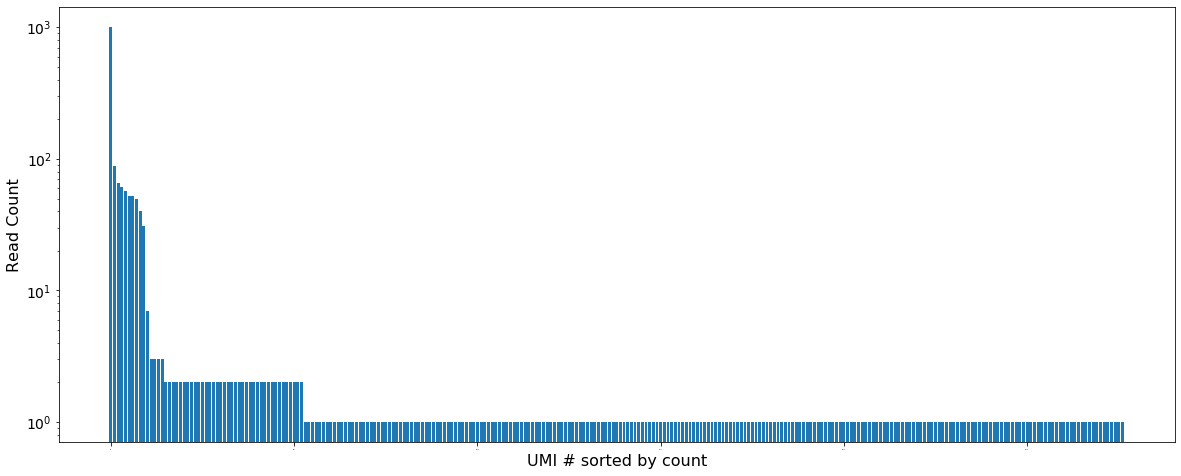

('GCTAAC', 1012) ('GGTCTA', 89) ('CATCAT', 66) ('GCTTCC', 61) ('CTAAAT', 57) ('CATAGA', 52) ('TAATTG', 52) ('TGCTAA', 50) ('AAGTTT', 40) ('TCCTCA', 31) ('TCTAAC', 7) ('AAGGTC', 3) ('GATAAC', 3) ('AGTTTG', 3) ('GACGAA', 3) ('GCGTAG', 2) ('AAGCAA', 2) ('CTAACT', 2) ('TGAGAA', 2) ('TGTCGT', 2) ('CGAAAC', 2) ('CACCTA', 2) ('GAAGCA', 2) ('AACCAT', 2) ('GACAAC', 2) ('ACTCTG', 2) ('ACAAAT', 2) ('TCATTC', 2) ('GCGGGG', 2) ('GGATGG', 2) ('GGAATA', 2) ('CTACTA', 2) ('AAACTC', 2) ('TTGTAT', 2) ('TCCCGA', 2) ('ATCACC', 2) ('AGATTC', 2) ('CTTGGG', 2) ('AGAGGC', 2) ('AAGCCC', 2) ('GTACTC', 2) ('TTGCCA', 2) ('AAGGAG', 2) ('TTTGGG', 2) ('AATGTG', 2) ('GCTACA', 2) ('CACAAA', 2) ('TATAGC', 2) ('TGATGA', 2) ('GACGCC', 2) ('TAAAAG', 2) ('GCGAAC', 2) ('AGCCGG', 2) ('GTAGAT', 1) ('GTCTAC', 1) ('GGACGA', 1) ('TAGTGT', 1) ('CTAAGA', 1) ('CTTACC', 1) ('TTATTG', 1) ('GTCACC', 1) ('GAAGTA', 1) ('GTCAAA', 1) ('GATCGA', 1) ('TTAGAC', 1) ('AACCGC', 1) ('CAGTGA', 1) ('AATATT', 1) ('AACACG', 1) ('AACTAG', 1) ('AGTAAG

In [22]:
# Print-out of UMIs with counts
UMI_dist_plot("Sample", "Log", True, True)

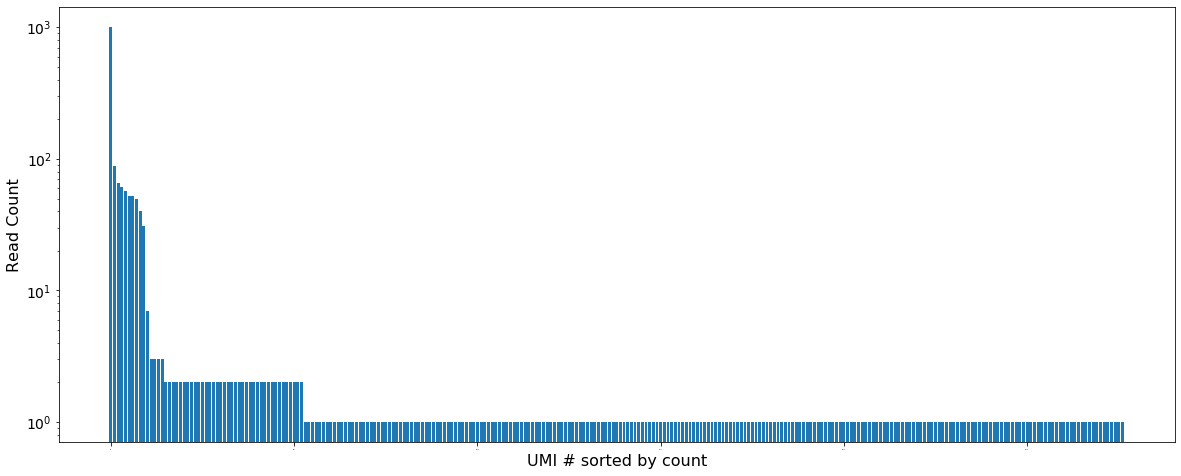

1012 89 66 61 57 52 52 50 40 31 7 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


In [23]:
# Print-out of counts only
UMI_dist_plot("Sample", "Log", False, True)

## .fastq File Output

In [24]:
help(write_fastq)

Help on function write_fastq in module __main__:

write_fastq(sample_name, file_name)
    Takes in sample name and writes reads to fastq file
    Inputs:
        sample_name = sample name as string
        file_name = output file name as string
    Outputs:
        .fastq file in same working directory containing filtered reads



In [25]:
#For this line to work correctly, create a sub-folder named InsertionReads
write_fastq("Sample", "InsertionReads//Sample.fastq")

Reads written to: InsertionReads//Sample.fastq


In [26]:
write_fastq("IB43-ID4_uL", "InsertionReads//IB43-ID4_uL.fastq")

Reads written to: InsertionReads//IB43-ID4_uL.fastq


In [27]:
write_fastq("IB43-ID9_uL", "InsertionReads//IB43-ID9_uL.fastq")

Reads written to: InsertionReads//IB43-ID9_uL.fastq


In [28]:
write_fastq("IB43-ID17_uL", "InsertionReads//IB43-ID17_uL.fastq")

Reads written to: InsertionReads//IB43-ID17_uL.fastq


In [29]:
write_fastq("IB43-ID19_uL", "InsertionReads//IB43-ID19_uL.fastq")

Reads written to: InsertionReads//IB43-ID19_uL.fastq


## Deprecated Code

In [ ]:
#Other packages
from Bio import motifs
from Bio import pairwise2
import pickle
from sklearn import preprocessing
from Bio.Seq import Seq

In [ ]:
EXPERIMENT_MARKER = '.fastq'

In [ ]:
def ham_dist(str1, str2):
    return sum(ch1 != ch2 for ch1,ch2 in zip(str1,str2))

 #ham_dist(target_match, read_sequence_f[:len(target_match)])<=3:

In [ ]:
def compare_aligned_nucleotides(ref, seq, return_mismatched_bases = False, num_mismatched_bases = 0):
    counter = 0
    for ref_b, seq_b in zip(ref,seq):
        if ref_b != seq_b and ref_b != 'N':
            break
        counter += 1
    if return_mismatched_bases:
        bases = seq_b[counter+1:counter+1+num_mismatched_bases]
        return(counter, bases)
    else:
        return counter

In [ ]:
def compare_aligned_nucleotides_v2(ref, seq):
    ref = Seq(ref.upper())
    seq = Seq(seq.upper())
    alignment = pairwise2.align.localxd(ref,seq, -1000, -10, -4, -0.1, penalize_end_gaps = False, one_alignment_only=True)
    gap_counter = 0
    mismatch_counter = 0
    counter = 0
    last_matching_base = 0
    for ref_b, seq_b in zip(alignment[0][0], alignment[0][1]):
        if seq_b == '-':
            gap_counter += 1
        elif ref_b != seq_b and ref_b != 'N':
            mismatch_counter +=1
        elif ref_b == seq_b or ref_b == 'N':
            gap_counter = 0
            mismatch_counter = 0
            last_matching_base = counter

        if gap_counter > 4 or mismatch_counter > 3:
            break
        
        counter += 1
            
    return last_matching_base

In [ ]:
pickle.dump(data, open('data.p', 'wb'))

In [ ]:
# Load data if starting a new session
data = pickle.load( open( "data.p", "rb" ) )

In [ ]:
## Plot Insertions
for sample in data:
    name = sample[0]
    insertions = sample[1]
    insertions['index'] = np.array(insertions.index.tolist())
    insertions.to_csv(name + '_positions.csv')

In [ ]:
#Get Pam data
for sample in data[1:]:
    #Get Data and Control
    name = sample[0]
    print(name)
    pams = sample[1].groupby(lambda x:x[-6:]).sum()
    control = data[0][1].groupby(lambda x:x[-6:]).sum()
    name_c = data[0][0]
    
    #Normalize by Number of Reads
    pams_sum = pams/pams.sum()
    control_sum = control/control.sum()
    
    #Get pams with okay number of reads
    control_ok = control_sum >= control_sum.quantile(0.25).values[0]
    pams_sum = pams_sum.loc[control_ok[name_c]==True,:]
    control_sum = control_sum.loc[control_ok[name_c]==True,:]
    
    
    #Normalize by Control
    pams_norm = pd.DataFrame(np.divide(pams_sum.values, control_sum.values), index = pams_sum.index)
    pams_norm = pams_norm.replace([np.inf, -np.inf,0], 1e-9)
    pams_norm.groupby(lambda x:x[-4:]).sum().to_csv(name + '_norm_reads_for_wheel.csv')
    
    #Sort Data and log2
    sorted_pams = pams_norm.sort_values(by=0, ascending = False)
    sorted_pams = sorted_pams.apply(np.log2)
    
    #Make data for PAM wheel
    pam_wheel_data = sorted_pams.to_csv(name + '_log2fc.csv')

    #Get Significant PAMS and create sequence motifs
    sig_pams = sorted_pams.loc[sorted_pams[0]>4].index.tolist()
    #sig_pams_down = sorted_pams.loc[sorted_pams[0]<-2].index.tolist()
    #num_pams = int(len(sorted_pams)*p_pams)
    #sig_pams = sorted_pams.iloc[0:num_pams, :].index.tolist()
    pam_seq = []
    for pam in sig_pams:
        pam_seq.append(Seq(pam))
    motif = motifs.create(pam_seq)
    print(motif)
    print('\n')
#     pam_seq_down = []
#     for pam in sig_pams_down:
#         pam_seq_down.append(Seq(pam))
#     motif_down = motifs.create(pam_seq_down)
#    print(motif_down)                  